In [65]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.naive_bayes import ComplementNB


from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.word2vec import Word2Vec, LineSentence
from gensim.models import KeyedVectors

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

from textblob import TextBlob

[nltk_data] Downloading package stopwords to /home/kirill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load and inspect dataset
In this section I'll load the data and inspect for basic info such as missing data, categorical features etc.

In [66]:
data_file = 'test_task_DS.xlsx'

df = pd.read_excel(data_file)
df.sample(5)

,Unnamed: 0,id,case_size,description,our_category,pack_desc,wholesale_price,initcat
38263,38263,730551,6,Nestle Frosted Shreddies PM £2.59,"Cereals,rice, their products",500g,11.95,Cereals & Muesli
50058,50058,895342,1,Ripple Coffee Cups 16oz Black,Housing,Pack of 500,37.99,DISPOSABLES
26633,26633,144768,12,CHUPA CHUPS BUBBLY COTTON GUM,Sweets and sugars,11G,3.09,Confectionery - Mints & Gum
25855,25855,143990,12,MILLIONS APPLE BAG PM 1.00,Sweets and sugars,100G,7.15,Confectionery - Sweets
16347,16347,93503,7,Kelloggs Bran Flakes 7x500g,"Cereals,rice, their products",500g,17.95,Breakfast Cereals


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86921 entries, 0 to 86920
Data columns (total 8 columns):
Unnamed: 0         86921 non-null int64
id                 86921 non-null int64
case_size          86776 non-null object
description        86920 non-null object
our_category       86921 non-null object
pack_desc          86749 non-null object
wholesale_price    86921 non-null float64
initcat            86921 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 5.3+ MB


In [68]:
df.describe()

,Unnamed: 0,id,wholesale_price
count,86921.000000,86921.000000,86921.000000
mean,48883.934573,409065.605124,35.645962
std,33113.449066,349166.698226,177.920812
min,0.000000,13241.000000,0.000000
25%,21730.000000,75083.000000,5.990000
50%,43460.000000,315524.000000,10.830000
75%,73969.000000,767429.000000,20.190000
max,121249.000000,909190.000000,9999.000000


In [69]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)  # drop this column because of useless

### EDA
In this section I'll inspect data with visualization techniques

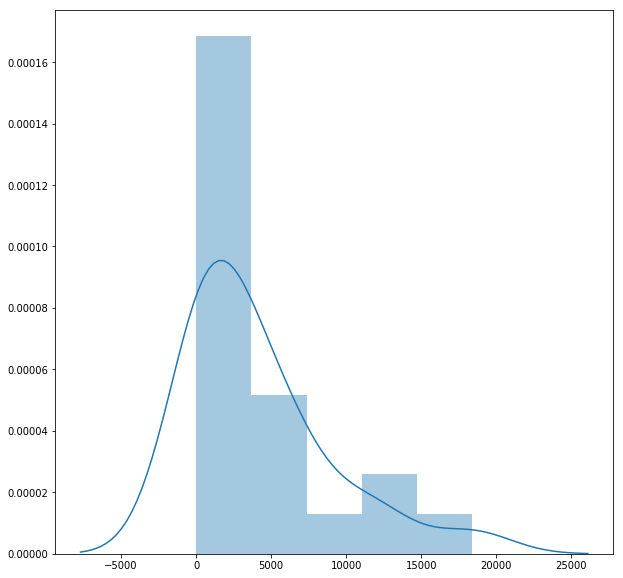

In [70]:
# I'll start from a label column our_category
value_counts = df['our_category'].value_counts().values

_ = plt.figure(figsize=(10, 10))
sns.distplot(value_counts)
plt.show()

# here i saw that our data are unbalanced

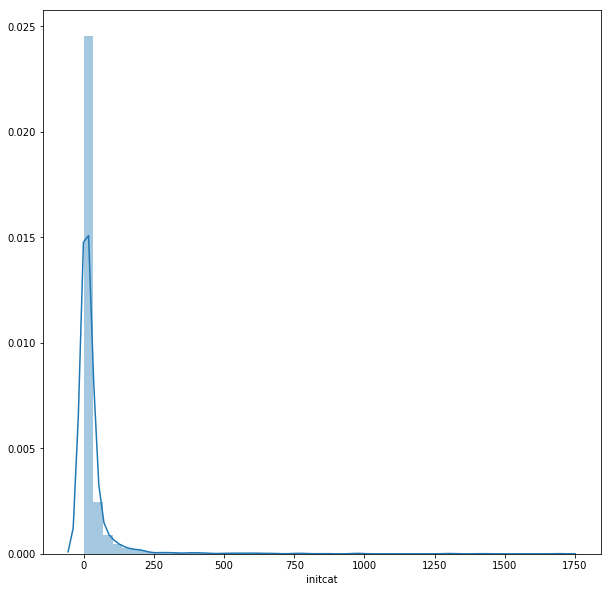

In [71]:
# now let's see the distribution of initcat columns

value_counts = df['initcat'].value_counts()

_ = plt.figure(figsize=(10, 10))
sns.distplot(value_counts)
plt.show()

{'Beverages': 0, 'Housing': 1, 'Sweets and sugars': 2, 'Meat,eggs and their products': 3, 'Vegetables and their product': 4, 'Ready meals': 5, 'Spices and condiments': 6, 'Fruits and their products': 7, 'Cereals,rice, their products': 8, 'Milk and milk products': 9, 'Tobacco': 10, 'Fish and shellfish': 11, 'Roots, tubers, plantains and': 12, 'Fats and oils': 13, 'Legumes and their products': 14, 'Seeds, nuts and their produc': 15, 'Foods for particular uses': 16, 'Stationery': 17, 'Food additives': 18, 'Food supplements and similar': 19, 'Fats ans oils': 20}


Text(0, 0.5, 'Price')

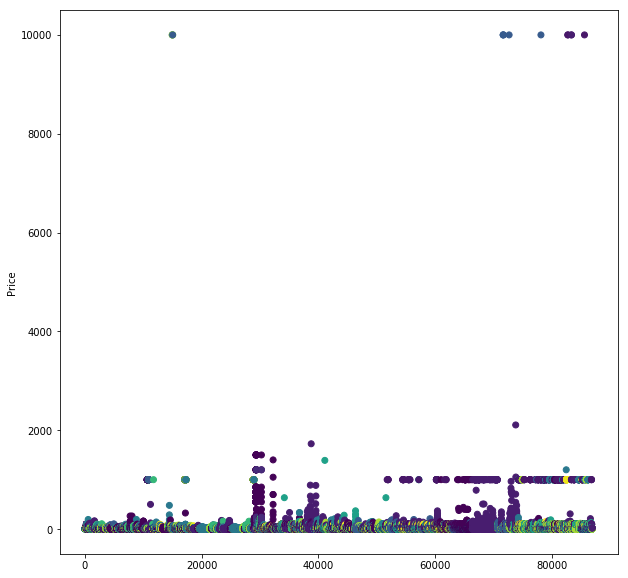

In [72]:
# price by category here we see some outliers that should be deleted from data
number_of_categories = dict(zip(df['our_category'].value_counts().index, range(len(df['our_category'].value_counts()))))
colors = np.random.rand(len(number_of_categories))
print(number_of_categories)
color = []
for i in df['our_category'].values:
    color.append(colors[number_of_categories[i]])

_ = plt.figure(figsize=(10, 10))
plt.scatter(x=range(len(df['wholesale_price'])), y=df['wholesale_price'].values, c=color)
plt.ylabel('Price')

# I wont delete those records because I'll use only text columns

### Dealing with text data
I decided to process text data into vector representation for that I need to do some processing steps such as lowering, deleting punctuation, deleting most/least frequent words and stemming.

In [73]:
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

word2vec_model = Word2Vec(size=100, min_count=1)

In [74]:
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def get_txt(s):
    if s.isdecimal():
        return 'count'
    reg_ex = r"[a-zA-z]*"
    match = re.findall(reg_ex, s)
    while '' in match:
        match.remove('')
    return ' '.join(x.lower() for x in match)

In [75]:
df['description'] = df['description'].astype('str')
print(df.shape)

df['description'] = df['description'].apply(lambda x: " ".join(i.lower() for i in x.split()))
print('Done 1/7')

df['description'] = df['description'].str.replace('[^\w\s]', '')
print('Done 2/7')

df['description'] = df['description'].apply(lambda x: " ".join(i for i in x.split() if i not in stop_words))
print('Done 3/7')

most_freq = list(pd.Series(" ".join(df['description']).split()).value_counts()[:10].index)
least_freq = list(pd.Series(" ".join(df['description']).split()).value_counts()[-10:].index)

df['description'] = df['description'].apply(lambda x: " ".join(i for i in x.split() if i not in most_freq))
print('Done 4/7')

df['description'] = df['description'].apply(lambda x: " ".join(i for i in x.split() if i not in least_freq))
print('Done 5/7')

df['description'] = df['description'].apply(lambda x: [stemmer.stem(word) for word in x.split()])
print('Done 6/7')

word2vec_model.build_vocab(df['description'].values)
vocab_len = word2vec_model.corpus_count
keyed_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
word2vec_model.build_vocab([list(keyed_vectors.vocab.keys())], update=True)
word2vec_model.intersect_word2vec_format(word2vec_output_file, binary=False, lockf=1.0)
word2vec_model.train(df['description'].values, total_examples=vocab_len, epochs=word2vec_model.iter)

df['desc_word2vec'] = df['description'].apply(lambda x: np.sum([word2vec_model[i] for i in x], axis=0) / len(x))
print('Done 7/7')

df = df.dropna()
print(df['desc_word2vec'].shape)

(86921, 7)
Done 1/7
Done 2/7
Done 3/7
Done 4/7
Done 5/7
Done 6/7


/home/kirill/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
/home/kirill/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Done 7/7
(86740,)


In [76]:
df['pack_desc'] = df['pack_desc'].astype('str')
print(df.shape)

df['pack_desc'] = df['pack_desc'].apply(lambda x: get_txt(str(x)))
print('Done 1/4')

df['pack_desc'] = df['pack_desc'].str.replace('[^\w\s]', '')
print('Done 2/4')

df['pack_desc'] = df['pack_desc'].apply(lambda x: [stemmer.stem(word) for word in x.split()])
print('Done 3/4')

word2vec_model.build_vocab(df['pack_desc'].values, update=True)
word2vec_model.train(df['pack_desc'].values, total_examples=len(df['pack_desc']), epochs=word2vec_model.iter)

df['pack_desc_word2vec'] = df['pack_desc'].apply(lambda x: np.sum([word2vec_model[i] for i in x], axis=0) / len(x))
print('Done 4/4')

df = df.dropna()
print(df['pack_desc_word2vec'].shape)

(86740, 8)
Done 1/4
Done 2/4
Done 3/4


/home/kirill/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  
W0816 13:14:46.110510 140671502632768 base_any2vec.py:1182] Effective 'alpha' higher than previous training cycles
/home/kirill/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


Done 4/4
(85649,)


### Preapring inputs and labels for training

In [77]:
x_data = np.empty((len(df), 100), dtype=np.float32)

for i, val in enumerate(df[['desc_word2vec', 'pack_desc_word2vec']].values):
    x_data[i] = np.sum(val, axis=0)

y_data = df[['our_category', 'id']]

# scaling data
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

# splitting into train-test sets
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.1)

train_indices, test_indices = train_y['id'].values, test_y['id'].values
train_y, test_y = train_y['our_category'].values, test_y['our_category'].values

print(train_x.shape, test_x.shape)

(77084, 100) (8565, 100)


In [78]:
# encoding labels into one-hot vectors
encoder = OneHotEncoder()

enc_data = [[i] for i in number_of_categories.keys()]
encoder.fit(enc_data)

train_y = encoder.transform(train_y.reshape(-1, 1)).toarray()
test_y = encoder.transform(test_y.reshape(-1, 1)).toarray()

In [79]:
print(np.isnan(train_y).any())
print(np.isnan(train_x).any())

False
False


In [80]:
# baseline will be always predicting the 1st class
y_pred = np.zeros(len(test_y))

print(f1_score(np.argmax(test_y, axis=1), y_pred, average='micro'))
print(f1_score(np.argmax(test_y, axis=1), y_pred, average='macro'))

0.20758902510215996
0.01719037029875278


/home/kirill/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
# i decided to use dense network for word2vec inputs

from keras.models import Model
from keras.layers import Dense, Input, Dropout, LeakyReLU, ReLU
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

reg = l2(0.0002)
prob = 0.2

inpt = Input(shape=(100, ))
dense = Dense(100)(inpt)
relu = ReLU()(dense)

dense = Dense(1024, kernel_regularizer=reg)(relu)
relu = ReLU()(dense)

do = Dropout(prob)(relu)
dense = Dense(1024, kernel_regularizer=reg)(do)
relu = ReLU()(dense)

do = Dropout(prob)(relu)
dense = Dense(1024, kernel_regularizer=reg)(do)
relu = ReLU()(dense)

do = Dropout(prob)(relu)
dense = Dense(1024, kernel_regularizer=reg)(do)
relu = ReLU()(dense)

do = Dropout(prob)(relu)
dense = Dense(1024, kernel_regularizer=reg)(do)
relu = ReLU()(dense)

do = Dropout(prob)(relu)
dense = Dense(1024, kernel_regularizer=reg)(do)
relu = ReLU()(dense)


outs = Dense(21, activation='softmax')(relu)

model = Model(inpt, outs)

In [100]:
callbacks = [
    ReduceLROnPlateau(factor=0.2, patience=5, mode='min'),
    ModelCheckpoint('classifier_100_features_{val_loss:.2f}.model', save_best_only=True, mode='min')
]

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(train_x, train_y, batch_size=128, epochs=30, validation_data=(test_x, test_y), callbacks=callbacks)

Train on 77084 samples, validate on 8565 samples
Epoch 1/30
77084/77084 [==============================] - 91s 1ms/step - loss: 0.5846 - acc: 0.8954 - val_loss: 0.6680 - val_acc: 0.8764
Epoch 2/30
77084/77084 [==============================] - 84s 1ms/step - loss: 0.5355 - acc: 0.9067 - val_loss: 0.6471 - val_acc: 0.8802
Epoch 3/30
77084/77084 [==============================] - 84s 1ms/step - loss: 0.5099 - acc: 0.9125 - val_loss: 0.6372 - val_acc: 0.8822
Epoch 4/30
77084/77084 [==============================] - 79s 1ms/step - loss: 0.4936 - acc: 0.9143 - val_loss: 0.6248 - val_acc: 0.8879
Epoch 5/30
77084/77084 [==============================] - 87s 1ms/step - loss: 0.4754 - acc: 0.9193 - val_loss: 0.6159 - val_acc: 0.8862
Epoch 6/30
77084/77084 [==============================] - 91s 1ms/step - loss: 0.4617 - acc: 0.9211 - val_loss: 0.6095 - val_acc: 0.8890
Epoch 7/30
77084/77084 [==============================] - 81s 1ms/step - loss: 0.4486 - acc: 0.9242 - val_loss: 0.6058 - val_acc:

KeyboardInterrupt: 

In [ ]:
_ = plt.figure(figsize=(5, 5))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [ ]:
_ = plt.figure(figsize=(5, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

0.9515469935785171
0.8876855887477707


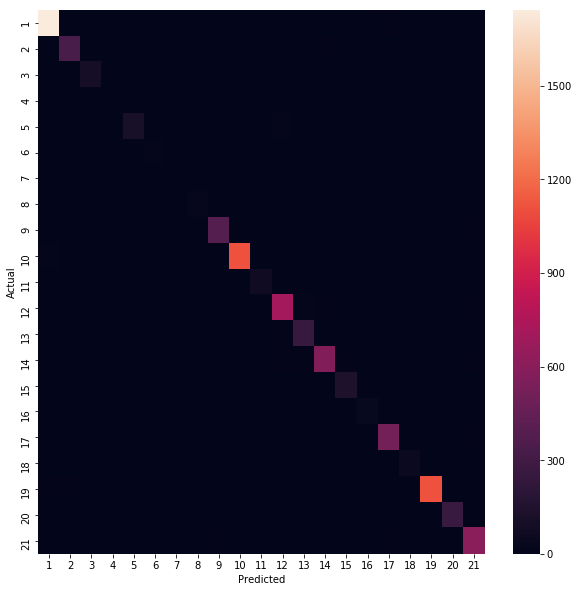

In [105]:
# since it's multiclass classification task
# for evaluating f1 score with averaging by micro and macro was choosen
from keras.models import load_model
model = load_model('classifier_100_features.model')


y_pred = model.predict(test_x)

print(f1_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1), average='micro'))
print(f1_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1), average='macro'))

cm = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))

_ = plt.figure(figsize=(10 ,10))
sns.heatmap(cm, xticklabels=range(1, 22), yticklabels=range(1, 22))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Making submission

In [106]:
probabilities = np.max(y_pred, axis=1)
label_index = encoder.inverse_transform(y_pred)

submission = pd.DataFrame(test_indices, columns=['id'])
submission['prediction'] = label_index
submission['pobabilities'] = probabilities
submission.sort_values(by='id', inplace=True)

data_file = 'test_task_DS.xlsx'
df = pd.read_excel(data_file)
df.drop(['Unnamed: 0', 'our_category', 'initcat'], axis=1, inplace=True)
df = df[df['id'].isin(test_indices)].sort_values(by='id')
df = df.join(submission.set_index('id'), on='id')

df.to_csv('submission.csv')